# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
   
    fig.canvas.draw()

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return y

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, y_train, y_test = load_data()

C:\Users\MERCER\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [15]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7352, 128, 9) (7352,)
(2947, 128, 9) (2947,)


# Prepare Data for Dynamic

# Prepare Data for static

In [28]:
import random

static_1 = np.where(y_train == 4)[0]
static_2 = np.where(y_train == 5)[0]
static_3 = np.where(y_train == 6)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

X_train_static = X_train[static]
y_train_static = y_train[static]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_train_static  = y_train_static - 4

print ("\n+++ DATA STATISTICS +++\n")
print ("train_static shape: ", X_train_static.shape,y_train_static.shape)

# Select dynamic HAR test data

static_1 = np.where(y_test == 4)[0]
static_2 = np.where(y_test == 5)[0]
static_3 = np.where(y_test == 6)[0]
static = np.concatenate([static_1, static_2, static_3])

X_test_static = X_test[static]
y_test_static = y_test[static]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_test_static  = y_test_static - 4

print ("test_static shape: ", X_test_static.shape,y_test_static.shape)

n_classes = 3

# Convert to one hot encoding vector
y_train_static_oh = np.eye(n_classes)[y_train_static]

y_test_static_oh = np.eye(n_classes)[y_test_static]


+++ DATA STATISTICS +++

train_static shape:  (4067, 128, 9) (4067,)
test_static shape:  (1560, 128, 9) (1560,)


In [19]:
print("Shape of y_train_static after OHE " , y_train_static_oh.shape)

print("Shape of y_test_static after OHE " , y_test_static_oh.shape)

Shape of y_train_static after OHE  (4067, 3)
Shape of y_test_static after OHE  (1560, 3)


In [21]:
# For static


timesteps_static = len(X_train_static[0])
input_dim_static = len(X_train_static[0][0])
n_classes_static = _count_classes(y_train_static_oh)

print(timesteps_static)
print(input_dim_static)
print(len(X_train_static))
print(n_classes_static)

128
9
4067
3


- Defining the Architecture of LSTM

## Dynamic Model

# Static Model

In [22]:
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding,Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam


model_static = Sequential()


model_static.add(Conv1D(50, 3, input_shape=(128, 9), activation='tanh',kernel_initializer = 'he_normal'))
model_static.add(MaxPooling1D(2))
model_static.add(BatchNormalization())
model_static.add(Dropout(0.2))


model_static.add(Conv1D(100, 3, activation='tanh',kernel_initializer = 'he_normal'))
model_static.add(MaxPooling1D(2))
model_static.add(BatchNormalization())
model_static.add(Dropout(0.2))



model_static.add(LSTM(32,activation = 'tanh',kernel_initializer = 'he_normal',return_sequences = True))
model_static.add(Dropout(0.5))


model_static.add(LSTM(80,activation = 'tanh',kernel_initializer = 'he_normal',return_sequences = True))
model_static.add(Dropout(0.5))



model_static.add(Flatten())


model_static.add(Dense(3, activation='sigmoid'))



model_static.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = 'adam')

model_static.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 50)           1400      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 50)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 50)            200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 100)           15100     
_________________________________________________________________
max_pooling1d_2 (MaxP

In [23]:
# Training the model
history_static= model_static.fit(X_train_static,
          y_train_static_oh,
          batch_size=10,
          validation_data=(X_test_static, y_test_static_oh),
          epochs=50)

Instructions for updating:
Use tf.cast instead.
Train on 4067 samples, validate on 1560 samples
Epoch 1/50
4067/4067 [==============================] - 47s 12ms/step - loss: 0.3465 - acc: 0.8498 - val_loss: 0.2998 - val_acc: 0.8699
Epoch 2/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.3085 - acc: 0.8716 - val_loss: 0.2808 - val_acc: 0.8827
Epoch 3/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.2797 - acc: 0.8844 - val_loss: 0.2864 - val_acc: 0.8917
Epoch 4/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.2659 - acc: 0.8908 - val_loss: 0.2955 - val_acc: 0.8705
Epoch 5/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.2672 - acc: 0.8916 - val_loss: 0.2288 - val_acc: 0.8981
Epoch 6/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.2507 - acc: 0.8967 - val_loss: 0.2000 - val_acc: 0.9263
Epoch 7/50
4067/4067 [==============================] - 43s 11ms/step - loss: 0.2435 - a

## Plot o loss

Test score: 0.1270274377493473
Test accuracy: 0.9551282051282052


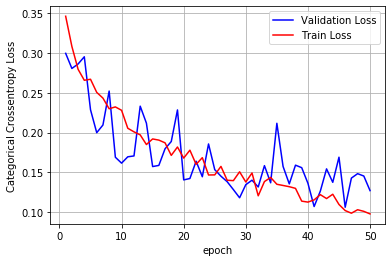

In [24]:
score = model_static.evaluate(X_test_static, y_test_static_oh, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history_static.history['val_loss']
ty = history_static.history['loss']
plt_dynamic(x, vy, ty, ax)

## Plot On Accuracy

Test score: 0.1270274377493473
Test accuracy: 0.9551282051282052


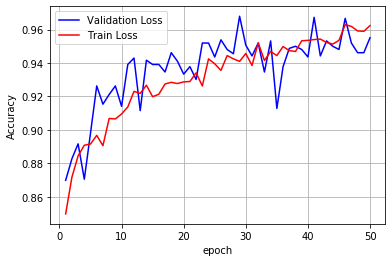

In [25]:
score = model_static.evaluate(X_test_static, y_test_static_oh, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history_static.history['val_acc']
ty = history_static.history['acc']
plt_dynamic(x, vy, ty, ax)

# Confusion Matrix

In [26]:
confusion_matrix(y_test_static_oh, model_static.predict(X_test_static))

Pred,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,
WALKING,452,0,39
WALKING_DOWNSTAIRS,0,537,0
WALKING_UPSTAIRS,31,0,501


# Result on static data

In [27]:
score_static =  model_static.evaluate(X_test_static, y_test_static_oh)

print("********************************************************************************************************")
print("|                                                                                                      |")
print("|                                                                                                      |")
print("  Loss & Accuracy of test data on Static set :",score_static )
print("|                                                                                                      |")
print("|                                                                                                      |")
print("********************************************************************************************************")


1560/1560 [==============================] - 2s 1ms/step
********************************************************************************************************
|                                                                                                      |
|                                                                                                      |
  Loss & Accuracy of test data on Static set : [0.1270274377493473, 0.9551282051282052]
|                                                                                                      |
|                                                                                                      |
********************************************************************************************************
